# Membership Inference over Diffusion-models-based Synthetic Tabular Data (MIDST) Challenge @ SaTML 2025.

## White Box Single Table Competition
Welcome to the MIDST challenge!

The MIDST challenge is a multi-track competition aiming to quantitatively evaluate the privacy of synthetic tabular data generated by diffusion models, with a specific focus on its resistance to membership inference attacks (MIAs).

This competition focuses on White Box MIA on tabular diffusion models trained on a single table transaction dataset. The schema of the transaction dataset is as follows:
| trans_id | account_id | trans_date | trans_type | operation | amount  | balance  | k_symbol | bank | account |
|----------|------------|------------|------------|-----------|---------|----------|----------|------|---------|
| integer  | integer    | integer    | integer    | integer   | float   | float    | integer  | integer | integer |

MIA will be performed over two state-of-the-art methods [TabSyn](https://arxiv.org/pdf/2310.09656) and [TabDDPM](https://arxiv.org/pdf/2209.15421). A collection of TabSyn and TabDDPM models will be trained on random subsets of the transaction dataset. The goal is to create an approach (MIA) that can distinguish between samples used to train a model (train data) and other data randomly sampled from the transaction dataset (holdout data) given the model and it's output synthetic data. The `final` set includes 20 models, each with its own set of challenge points (ie train and holdout data), to evaluate solutions on. To facilitate designing an attack, 30 `train` models are provided with comprehensive information about the model, training data and output synthetic data. Additionally, 20 `dev` models are provided to assist in evaluating the effectiveness of attacks prior to making a final submission to the `final` set. Participants can choose to perform MIA over one of or both TabSyn and TabDDPM. In the case of both, the attack that obtains the highest score will be used to rank the submission. A high level summary of the competition is below:
![wbox_diagram_final](https://github.com/user-attachments/assets/2ebb5eed-a6e3-433a-8769-4310b7fbc822)

This notebook will walk you through the process of creating and packaging a submission to the white box single table challenge.

## Package Imports and Evironment Setup

Ensure that you have installed the proper dependenices to run the notebook. The environment installation instructions are available [here](https://github.com/VectorInstitute/MIDSTModels/tree/main/starter_kits). Now that we have verfied we have the proper packages installed, lets import them and define global variables:

In [1]:
import csv
import os
import random
import zipfile

from pathlib import Path
from functools import partial
from typing import Callable, Any

import numpy as np
import torch

from tqdm.notebook import tqdm
from data import get_challenge_points
from metrics import get_tpr_at_fpr

In [2]:
TABDDPM_DATA_DIR = "tabddpm_white_box"
TABSYN_DATA_DIR = "tabsyn_white_box"

## Data

Next, lets download and extract the data for the competition:

In [3]:
!gdown 1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh
!unzip -qq -o tabddpm_white_box.zip

Downloading...
From (original): https://drive.google.com/uc?id=1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh
From (redirected): https://drive.google.com/uc?id=1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh&confirm=t&uuid=a7c312e3-c352-4a19-a1f4-5314644c99a1
To: /home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box.zip
100%|██████████████████████████████████████| 1.22G/1.22G [02:04<00:00, 9.78MB/s]


**Note:** If there is an issue with the download (ie throttled for downloading too many files with gdown) you can simply download the zip manually from this [link](https://drive.google.com/file/d/1DGqz9U8IKLLZrhB3cKm0SEaoU_MyakKh/view?usp=drive_link) and extract it in the same directory this notebook exists.

In [4]:
!gdown 1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb
!unzip -qq -o tabsyn_white_box.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb
From (redirected): https://drive.google.com/uc?id=1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb&confirm=t&uuid=1af2230a-24de-4909-8a73-9e6a7e6faad6
To: /home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabsyn_white_box.zip
100%|██████████████████████████████████████| 1.29G/1.29G [01:49<00:00, 11.8MB/s]


**Note:** If there is an issue with the download (ie throttled for downloading too many files with gdown) you can simply download the zip manually from this [link](https://drive.google.com/file/d/1Os7f3l2A9SEdgB2V6oUK52k5U89MLTlb/view?usp=drive_link) and extract it in the same directory this notebook exists.

### Contents
The archives extracted under the `tabddpm_white_box` and `tabsyn_white_box` each contain 3 subdirectories:

- `train`: Comprehensive information (ie model weights+architecture, training data, output synthetic data etc.) about the set of shadow models. Use these to develop your attacks without having to train your own models.
- `dev`: Set of challenge points. Membership predictions for these challenges will be used to evaluate submissions during the competition and update the live scoreboard in CodaBench.
- `final`: Set of challenge points. Membership predictions for these challenges will be used to evaluate submissions when the competition closes and to determine the final ranking.

The contents of the `train`, `dev` and `final` subdirectory of `tabddpm_white_box` and `tabsyn_white_box` slightly differ - this stems from the fact that each approach has its own set of artifacts from training. Below we outline the contents of the `train` for both TabSyn and TabDDPM along with the `dev` and `final` which include the same file types for each method.

<table> <tr> <th>Model - Stage</th> <th>File Name</th> <th>Description</th> </tr> <!-- TabDDPM - Train --> <tr> <td rowspan="8"><strong>TabDDPM - Train</strong></td> <td>train_with_id.csv</td> <td>Transaction samples used to train the model</td> </tr> <tr> <td>trans_domain.json</td> <td>Transaction data domain file indicating the domain information for each column</td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>challenge_label.csv</td> <td>The labels for the set of challenge points</td> </tr> <tr> <td>trans_label_encoders.pkl</td> <td>Pickled label encoders used in data preprocessing</td> </tr> <tr> <td>cluster_ckpt.pkl</td> <td>Pickled cluster checkpoint (Clustering does not impact training or sampling in single-table scenarios; the checkpoint exists solely because the multi-table pipeline was used for TabDDPM model.)</td> </tr> <tr> <td>None_trans_ckpt.pkl</td> <td>Pickled checkpoint of trained TabDDMP model</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabDDPM - Dev --> <tr> <td rowspan="6"><strong>TabDDPM - Dev</strong></td>  <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <!-- challenge_label.csv is excluded --> <tr> <td>trans_label_encoders.pkl</td> <td>Pickled label encoders used in data preprocessing</td> </tr>  <tr> <td>cluster_ckpt.pkl</td> <td>Pickled cluster checkpoint (Clustering does not impact training or sampling in single-table scenarios; the checkpoint exists solely because the multi-table pipeline was used for TabDDPM model.) </td> </tr> <tr> <td>None_trans_ckpt.pkl</td> <td>Pickled checkpoint of trained TabDDMP model</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic data output from the trained model</td></tr> <!-- TabDDPM - Eval --> <tr> <td rowspan="6"><strong>TabDDPM - Final</strong></td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>trans_label_encoders.pkl</td> <td>Pickled label encoders used in data preprocessing</td> </tr> <tr> <td>cluster_ckpt.pkl</td> <td>Pickled cluster checkpoint (Clustering does not impact training or sampling in single-table scenarios; the checkpoint exists solely because the multi-table pipeline was used for TabDDPM model.)</td> </tr> <tr> <td>None_trans_ckpt.pkl</td> <td>Pickled checkpoint of trained TabDDMP model</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabSyn - Train --> <tr> <td rowspan="6"><strong>TabSyn - Train</strong></td> <td>train_with_id.csv</td> <td>Transaction samples used to train the model</td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>challenge_label.csv</td> <td>The labels for the set of challenge points</td> </tr> <tr> <td>model.pt</td> <td>Pickled checkpoint of trained diffusion model of Tabsyn</td> </tr> <tr> <td>vae/</td> <td>Model artifacts for trained VAE model of TabSyn</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabSyn - Dev --> <tr> <td rowspan="5"><strong>TabSyn - Dev</strong></td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>model.pt</td> <td>Pickled checkpoint of trained diffusion model of Tabsyn</td> </tr> <tr> <td>vae/</td> <td>Model artifacts for trained VAE model of TabSyn</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> <!-- TabSyn - Eval --> <tr> <td rowspan="5"><strong>TabSyn - Final</strong></td> </tr> <tr> <td>challenge_with_id.csv</td> <td>Challenge points sampled from train data and holdout data</td> </tr> <tr> <td>model.pt</td> <td>Pickled checkpoint of trained diffusion model of Tabsyn</td> </tr> <tr> <td>vae/</td> <td>Model artifacts for trained VAE model of TabSyn</td> </tr> <tr> <td>trans_synthetic.csv</td> <td>Synthetic transaction data generated using the trained model</td> </tr> </table>


## Task

Your task as a competitor is to produce, for each model in `dev` and `final` in `tabddpm_white_box` and `tabsyn_white_box`, a CSV file listing your confidence scores (values between 0 and 1) for the membership of the challenge examples. You must save these scores in a `prediction.csv` file and place it in the same folder as the corresponding model. A submission to the challenge is an an archive containing just these `prediction.csv` files.

**You must submit predictions for both `dev` and `final` when you submit to CodaBench.**

In the following, we will show you how to correctly package a submission to the competition. To focus solely on the submission logic, the attack model will simply generate random predictions. Let's start by creating baseline attack models `tabddpm_attack_model` and `tabsyn_attack_model` based on their respective shadow models:

In [3]:
def get_attack_model(base_train_path: Path) -> Callable[[Any], float]:
    return lambda x : random.uniform(0, 1)

base_tabddpm_train_path = os.path.join(TABDDPM_DATA_DIR, "train")
base_tabsyn_train_path = os.path.join(TABSYN_DATA_DIR, "train")
tabddpm_attack_model = get_attack_model(base_tabddpm_train_path)
tabsyn_attack_model = get_attack_model(base_tabsyn_train_path)

Using the attack model, we can obtain predictions for each point in the challenge point set for train, dev and final:

In [4]:
phases = ["train", "dev", "final"]

for base_dir, attack_model in zip([TABDDPM_DATA_DIR, TABSYN_DATA_DIR], [tabddpm_attack_model, tabsyn_attack_model]):
    for phase in phases:
        root = os.path.join(base_dir, phase)
        model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
        for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
            path = os.path.join(root, model_folder)
    
            challenge_points = get_challenge_points(path)
    
            predictions = torch.Tensor([attack_model(cp) for cp in challenge_points])
           
            assert torch.all((0 <= predictions) & (predictions <= 1))
            with open(os.path.join(path, "prediction.csv"), mode="w", newline="") as file:
                writer = csv.writer(file)
    
                # Write each value in a separate row
                for value in list(predictions.numpy().squeeze()):
                    writer.writerow([value])

## Scoring

Let's see how the attack does on `train`, for which we have the ground truth.
When preparing a submission, you can use part of `train` to develop an attack and a held-out part to evaluate your attack.

In [5]:
tpr_at_fpr_list = []
for base_dir in [TABDDPM_DATA_DIR, TABSYN_DATA_DIR]:
    predictions = []
    solutions  = []
    root = os.path.join(base_dir, "train")
    model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
    for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
        path = os.path.join(root, model_folder)
        predictions.append(np.loadtxt(os.path.join(path, "prediction.csv")))
        solutions.append(np.loadtxt(os.path.join(path, "challenge_label.csv"), skiprows=1))
    
    predictions = np.concatenate(predictions)
    solutions = np.concatenate(solutions)
    
    tpr_at_fpr = get_tpr_at_fpr(solutions, predictions)
    tpr_at_fpr_list.append(tpr_at_fpr)
    
    print(f"{base_dir.split('_')[0]} Train Attack TPR at FPR==10%: {tpr_at_fpr}")

final_tpr_at_fpr = max(tpr_at_fpr_list)
print(f"Final Train Attack TPR at FPR==10%: {final_tpr_at_fpr}")

tabddpm Train Attack TPR at FPR==10%: 0.09933333333333333
tabsyn Train Attack TPR at FPR==10%: 0.091
Final Train Attack TPR at FPR==10%: 0.09933333333333333


## Packaging the submission

Now we can store the predictions into a zip file, which you can submit to CodaBench. Importantly, we create a single zip file for dev and final. The structure of the submission is as follows:

```
└── root_folder
    ├── tabsyn_white_box
    │   ├── dev
    │   │   └── tabsyn_#
    │   │       └── prediction.csv
    │   └── final
    │       └── tabsyn_#
    │           └── prediction.csv
    └── tabddpm_white_box
        ├── dev 
        │   └── tabddpm_#
        │       └── prediction.csv
        └── final 
            └── tabddpm_# 
                └── prediction.csv
```
**Note:** The `root_folder` can have any name but it is important all of the subdirectories follow the above structure and naming conventions. 

If a participant is looking to submit an attack for only one of TabSyn and TabDDPM, they can simply omit the other directory (ie `tabddpm_white_box` or `tabsyn_white_box` from the root_folder).

In [6]:
with zipfile.ZipFile(f"white_box_single_table_submission.zip", 'w') as zipf:
    for phase in ["dev", "final"]:
        for base_dir in [TABDDPM_DATA_DIR, TABSYN_DATA_DIR]:
            root = os.path.join(base_dir, phase)
            model_folders = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
            for model_folder in sorted(model_folders, key=lambda d: int(d.split('_')[1])):
                path = os.path.join(root, model_folder)
                if not os.path.isdir(path): continue

                file = os.path.join(path, "prediction.csv")
                if os.path.exists(file):
                    # Use `arcname` to remove the base directory and phase directory from the zip path
                    arcname = os.path.relpath(file, os.path.dirname(base_dir))
                    zipf.write(file, arcname=arcname)
                else:
                    raise FileNotFoundError(f"`prediction.csv` not found in {path}.")

The generated white_box_single_table_submission.zip can be directly submitted to the dev phase in the CodaBench UI. Although this submission contains your predictions for both the dev and final set, you will only receive feedback on your predictions for the dev phase. The predictions for the final phase will be evaluated once the competiton ends using the most recent submission to the dev phase.

In [3]:
import json

from midst_models.single_table_TabDDPM.wb_complex_pipeline import (
    clava_clustering,
    clava_training,
    clava_load_pretrained,
    clava_synthesizing,
    load_configs,
)
from midst_models.single_table_TabDDPM.wb_pipeline_modules import load_multi_table
from midst_models.single_table_TabDDPM.tab_ddpm.gaussian_multinomial_diffsuion import GaussianMultinomialDiffusion

In [11]:
!pwd

/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits


In [4]:
# Load config
config_path = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/trans.json"
configs, save_dir = load_configs(config_path)

# Display config
json_str = json.dumps(configs, indent=4)
print(json_str)

{
    "general": {
        "data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/midst_models/single_table_TabDDPM/tabddpm_test",
        "exp_name": "train_1",
        "workspace_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/midst_models/single_table_TabDDPM/tabddpm_test",
        "sample_prefix": "",
        "test_data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/midst_models/single_table_TabDDPM/tabddpm_test"
    },
    "clustering": {
        "parent_scale": 1.0,
        "num_clusters": 50,
        "clustering_method": "both"
    },
    "diffusion": {
        "d_layers": [
            512,
            1024,
            1024,
            1024,
            1024,
            512
        ],
        "dropout": 0.0,
        "num_timesteps": 2000,
        "model_type": "mlp",
        "iterations": 200000,
        "batch_size": 4096,
        "lr": 0.0006,
        "gaussian_loss_type": "mse",
        "weight_decay": 1e-05,
        "scheduler": "cosine"
    },
    "classifier": {
        "d_laye

In [5]:
relation_order = [[None, 'trans']]

In [6]:
models = clava_load_pretrained(relation_order, save_dir)

None -> trans checkpoint found, loading...


/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
models

{(None,
  'trans'): {'diffusion': GaussianMultinomialDiffusion(
    (_denoise_fn): MLPDiffusion(
      (mlp): MLP(
        (blocks): ModuleList(
          (0): Block(
            (linear): Linear(in_features=128, out_features=512, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): Block(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (2): Block(
            (linear): Linear(in_features=1024, out_features=1024, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (3): Block(
            (linear): Linear(in_features=1024, out_features=1024, bias=True)
            (activation): ReLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (4): Block(
            (linear): Linear(in_features=1024, o

In [22]:
type(models[(None,'trans')]['diffusion'])

midst_models.single_table_TabDDPM.tab_ddpm.gaussian_multinomial_diffsuion.GaussianMultinomialDiffusion

In [7]:
model = models[(None,'trans')]['diffusion']
model

GaussianMultinomialDiffusion(
  (_denoise_fn): MLPDiffusion(
    (mlp): MLP(
      (blocks): ModuleList(
        (0): Block(
          (linear): Linear(in_features=128, out_features=512, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): Block(
          (linear): Linear(in_features=512, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (4): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dro

In [14]:
models[(None,'trans')]["diffusion"]._denoise_fn

MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=128, out_features=512, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=512, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (4): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (5): Block(
        (linear): Linear(in_features=1024, out

In [8]:
device = "cuda"

In [16]:
# import torch.nn.functional as F

# def index_to_log_onehot(x, num_classes):
#     onehots = []
#     for i in range(len(num_classes)):
#         onehots.append(F.one_hot(x[:, i], num_classes[i]))

#     x_onehot = torch.cat(onehots, dim=1)
#     log_onehot = torch.log(x_onehot.float().clamp(min=1e-30))
#     return log_onehot

# def calculate_reconstruction_loss(self=models[(None,'trans')]["diffusion"], x=0, t=0, out_dict={}):
#     """
#     Calculate reconstruction loss for both numerical and categorical features at timestep t.
    
#     Args:
#         x: Original input data (B x D)
#         t: Timestep tensor (B,)
#         out_dict: Dictionary containing additional model inputs
        
#     Returns:
#         total_loss: Per-sample reconstruction loss
#         numerical_loss: Per-sample numerical features reconstruction loss
#         categorical_loss: Per-sample categorical features reconstruction loss
#     """
#     b = x.shape[0]
#     device = "cuda"
    
#     # Split numerical and categorical features
#     x_num = x[:,:self.num_numerical_features]
#     x_cat = x[:,self.num_numerical_features:]
#     has_cat = x_cat.shape[1] > 0

#     # Calculate loss for numerical features
#     numerical_loss = torch.zeros(b, device=device)
#     if self.num_numerical_features > 0:
#         # Add noise to numerical features
#         noise = torch.randn_like(x_num)
#         x_num_t = self.gaussian_q_sample(x_num, t, noise=noise)
        
#         # Get model prediction
#         x_in = x_num_t
#         if has_cat:
#             log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes)
#             log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t)
#             x_in = torch.cat([x_num_t, log_x_cat_t], dim=1)
#         else:
#             x_in = torch.cat([x_num_t, torch.zeros((b, 0), device=device)], dim=1)
            
#         model_out = self._denoise_fn(x_in, t, **out_dict)
#         model_out_num = model_out[:, :self.num_numerical_features]
        
#         # Calculate MSE loss for numerical features
#         pred_x0 = self._predict_xstart_from_eps(x_num_t, t, model_out_num)
#         numerical_loss = ((pred_x0 - x_num) ** 2).mean(dim=1)

#     # Calculate loss for categorical features
#     categorical_loss = torch.zeros(b, device=device)
#     if has_cat:
#         log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes)
#         log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t)
        
#         # Get model prediction for categorical features
#         if self.num_numerical_features > 0:
#             x_in = torch.cat([x_num_t, log_x_cat_t], dim=1)
#         else:
#             x_in = log_x_cat_t
            
#         model_out = self._denoise_fn(x_in, t, **out_dict)
#         model_out_cat = model_out[:, self.num_numerical_features:]
        
#         # Calculate cross-entropy loss for categorical features
#         log_x0_recon = self.predict_start(model_out_cat, log_x_cat_t, t=t, out_dict=out_dict)
#         categorical_loss = -torch.sum(log_x_cat * log_x0_recon, dim=1)

#     total_loss = numerical_loss + categorical_loss
#     return total_loss, numerical_loss, categorical_loss

# def get_timestep_reconstruction_losses(self=models[(None,'trans')]["diffusion"], x=0, out_dict={}):
#     """
#     Calculate reconstruction losses for all timesteps.
    
#     Args:
#         x: Input data (B x D)
#         out_dict: Dictionary containing additional model inputs
        
#     Returns:
#         losses: Dictionary containing per-timestep losses
#     """
#     b = x.shape[0]
#     device = "cuda"
    
#     total_losses = []
#     numerical_losses = []
#     categorical_losses = []
    
#     for t in range(self.num_timesteps):
#         t_array = (torch.ones(b, device=device) * t).long()
#         total_loss, num_loss, cat_loss = calculate_reconstruction_loss(self,x, t_array, out_dict)
        
#         total_losses.append(total_loss)
#         numerical_losses.append(num_loss)
#         categorical_losses.append(cat_loss)
    
#     return {
#         'total_losses': torch.stack(total_losses, dim=1),  # B x T
#         'numerical_losses': torch.stack(numerical_losses, dim=1),  # B x T
#         'categorical_losses': torch.stack(categorical_losses, dim=1)  # B x T
#     }

In [17]:
# # For a single challenge point
# challenge_point = torch.from_numpy(np.array([1529,2,1,1648.0,13237.2,0,13,38488340]).reshape([1,8])).to(device)  # Your challenge point
# out_dict = {}  # Any additional model inputs

# # Get reconstruction losses for all timesteps
# losses = get_timestep_reconstruction_losses(self = models[(None,'trans')]["diffusion"],x=challenge_point, out_dict=out_dict)

# # Access different types of losses
# total_losses = losses['total_losses']  # Shape: B x T
# numerical_losses = losses['numerical_losses']  # Shape: B x T
# categorical_losses = losses['categorical_losses']  # Shape: B x T

RuntimeError: mat1 and mat2 must have the same dtype

In [61]:
model.to(device)

GaussianMultinomialDiffusion(
  (_denoise_fn): MLPDiffusion(
    (mlp): MLP(
      (blocks): ModuleList(
        (0): Block(
          (linear): Linear(in_features=128, out_features=512, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): Block(
          (linear): Linear(in_features=512, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (4): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dro

In [64]:
def compute_t_error(model, x, t):
    """
    Computes the reconstruction error at a specific timestep t.

    Args:
        model: Pretrained GaussianMultinomialDiffusion model.
        x: Input data tensor.
        t: Diffusion timestep (int or tensor).

    Returns:
        Reconstruction error tensor for each sample in x.
    """
    # Simulate the diffusion process
    x_t = model.gaussian_q_sample(x_start=x, t=torch.tensor([t] * len(x)).to(x.device))
    
    # Perform reverse denoising
    x_recon = model._denoise_fn(x_t, torch.tensor([t] * len(x)).to(x.device))
    
    # Compute reconstruction error (e.g., L2 norm)
    t_error = torch.norm(x - x_recon, p=2, dim=1)
    return t_error


In [65]:
model._denoise_fn   

MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=128, out_features=512, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=512, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (4): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (5): Block(
        (linear): Linear(in_features=1024, out

In [263]:
import torch
import torch.nn as nn

class QuantileRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super().__init__()
        layers = []
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dims[i - 1], hidden_dims[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))  # Dropout for regularization
        layers.append(nn.Linear(hidden_dims[-1], 1))  # Final output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [264]:
from torch import nn, optim
import matplotlib.pyplot as plt

# class QuantileRegressor(nn.Module):
#     def __init__(self, input_dim, hidden_dim=64):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, x):
#         return self.model(x)

def train_quantile_regressor(model, data, labels, alpha, epochs=200, lr=0.001):
    """
    Train a quantile regression model with pinball loss.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = lambda y_pred, y: torch.mean((y_pred - y) * ((y <= y_pred).float() - alpha))
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.squeeze(), labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [282]:
def train_bagged_regressors(data, labels, num_models=5, alpha=0.05, epochs=50, lr=0.001):
    """
    Train multiple quantile regressors using bagging (bootstrap sampling) on GPU.
    """
    # Ensure data and labels are on the same device
    labels = labels.to(data.device)  # Move labels to the same device as data
    models = []
    for i in range(num_models):
        print(f"Training model {i + 1}/{num_models} on GPU...")
        
        # Bootstrap sampling
        indices = torch.randint(0, len(data), (len(data,),), device=data.device)  # Ensure indices are on the same device
        bootstrap_data = data[indices]  # Subset data
        bootstrap_labels = labels[indices]  # Subset labels

        # Initialize the model and optimizer
        model = QuantileRegressor(input_dim=data.shape[1]).to(data.device)  # Move model to GPU
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = lambda y_pred, y: torch.mean((y_pred - y) * ((y <= y_pred).float() - alpha))
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(bootstrap_data)
            loss = criterion(outputs.squeeze(), bootstrap_labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        # Append the trained model
        models.append(model)
    return models


def aggregate_predictions(models, data):
    """
    Aggregate predictions from bagged regressors using averaging.
    """
    predictions = torch.stack([model(data).squeeze() for model in models], dim=0)
    return predictions.mean(dim=0)  # Averaging predictions


In [276]:
def perform_membership_inference(models, x, threshold_alpha):
    """
    Perform membership inference using reconstruction errors and a quantile regression model.
    """
    errors = compute_t_error(model, x, t=5)  # Example timestep
    thresholds = models(x)
    predictions = (errors <= thresholds).float()  # Membership decision
    return predictions


In [29]:
!pwd

/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits


In [54]:
cd tabddpm_white_box/train/tabddpm_1

[Errno 2] No such file or directory: 'tabddpm_white_box/train/tabddpm_1'
/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1


/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [254]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the datasets
train_data = pd.read_csv("train_with_id.csv")
synthetic_data = pd.read_csv("trans_synthetic.csv")
challenge_data = pd.read_csv("challenge_with_id.csv")
challenge_labels = pd.read_csv("challenge_label.csv")

# Extract data and IDs
train_features = train_data.drop(columns=["trans_id",'account_id']).values
#train_features = train_features.drop(columns=["account_id"]).values
synthetic_features = synthetic_data.values
challenge_features = challenge_data.drop(columns=["trans_id","account_id"]).values
challenge_ground_truth = challenge_labels["is_train"].values

# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
synthetic_features = scaler.transform(synthetic_features)
challenge_features = scaler.transform(challenge_features)


In [56]:
challenge_ground_truth

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1])

In [ ]:
# # Prepare data for training bagged regressors
# synthetic_train_tensor = torch.tensor(synthetic_train, dtype=torch.float32).to(device)
# synthetic_train_errors = compute_reconstruction_errors(synthetic_train, model, t=50).to(device)

# # Train bagged quantile regressors
# num_bagged_models = 5  # Number of models in the ensemble
# bagged_models = train_bagged_regressors(synthetic_train_tensor, synthetic_train_errors, num_models=num_bagged_models)

# # Perform membership inference
# challenge_tensor = torch.tensor(challenge_features, dtype=torch.float32).to(device)
# challenge_errors = compute_reconstruction_errors(challenge_features, model, t=50).to(device)
# predicted_thresholds = aggregate_predictions(bagged_models, challenge_tensor).cpu().detach().numpy()
# membership_predictions = (challenge_errors.cpu().numpy() <= predicted_thresholds).astype(int)

# # Evaluate attack performance
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# accuracy = accuracy_score(challenge_ground_truth, membership_predictions)
# precision = precision_score(challenge_ground_truth, membership_predictions)
# recall = recall_score(challenge_ground_truth, membership_predictions)
# auc = roc_auc_score(challenge_ground_truth, membership_predictions)

# print(f"Membership Inference Attack Metrics:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"AUC: {auc:.4f}")


In [251]:
# Split synthetic data into training and validation sets
#synthetic_train, synthetic_val_ = train_test_split(train_features, test_size=0.2, random_state=42) # wrong as validation dataset same as training data

synthetic_train = train_features
synthetic_val = challenge_features

# Compute reconstruction errors for synthetic data
def compute_reconstruction_errors(data, model, t):
    errors = []
    for x in torch.tensor(data, dtype=torch.float32).to(device):
        x = x.unsqueeze(0)  # Add batch dimension
        error = compute_t_error(model, x, t)
        errors.append(error.item())
    return torch.tensor(errors, dtype=torch.float32)

# Reconstruction errors for synthetic training and validation data
synthetic_train_errors = compute_reconstruction_errors(synthetic_train, model, t=10)
synthetic_val_errors = compute_reconstruction_errors(synthetic_val, model, t=10)

Training model 1/10 on GPU...
Training model 2/10 on GPU...
Training model 3/10 on GPU...
Training model 4/10 on GPU...
Training model 5/10 on GPU...
Training model 6/10 on GPU...
Training model 7/10 on GPU...
Training model 8/10 on GPU...
Training model 9/10 on GPU...
Training model 10/10 on GPU...


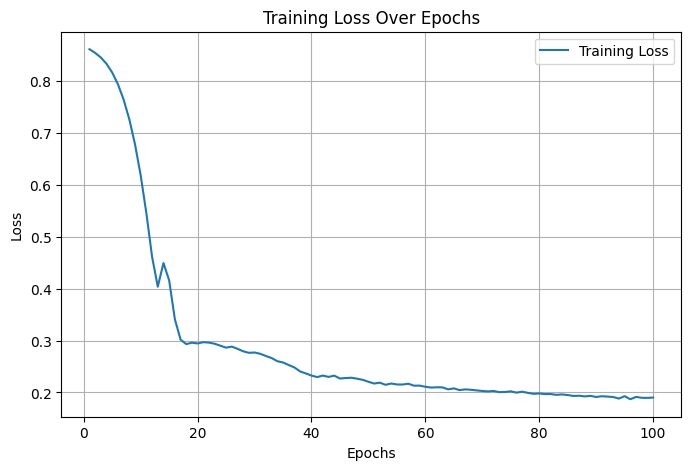

In [300]:
input_dim = synthetic_train.shape[1]
quantile_regressor = QuantileRegressor(input_dim=input_dim).to(device)
synthetic_train_tensor = torch.tensor(synthetic_train, dtype=torch.float32).to(device)

# Train bagged quantile regressors
num_bagged_models = 10  # Number of models in the ensemble
bagged_models = train_bagged_regressors(synthetic_train_tensor, synthetic_train_errors, num_models=num_bagged_models,alpha=0.10, epochs=100, lr=0.005)

train_quantile_regressor(
    quantile_regressor,
    synthetic_train_tensor,
    synthetic_train_errors.to(device),
    alpha=0.05,  # Set desired quantile (e.g., 5%)
    epochs= 100,
    lr=0.005,
)

In [301]:
# Compute reconstruction errors for challenge data
challenge_errors = compute_reconstruction_errors(challenge_features, model, t=10)

# Perform membership inference
challenge_tensor = torch.tensor(challenge_features, dtype=torch.float32).to(device)
#predicted_thresholds = quantile_regressor(challenge_tensor).squeeze().cpu().detach()
predicted_thresholds = aggregate_predictions(bagged_models, challenge_tensor).cpu().detach().numpy()
#membership_predictions = (challenge_errors <= predicted_thresholds).float().cpu().numpy()
# Ensure both are tensors for comparison
predicted_thresholds = torch.tensor(predicted_thresholds).to(challenge_errors.device)
membership_predictions = (challenge_errors <= predicted_thresholds).float().cpu().numpy()




from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# Compute evaluation metrics
accuracy = accuracy_score(challenge_ground_truth, membership_predictions)
# precision = precision_score(challenge_ground_truth, membership_predictions)
# recall = recall_score(challenge_ground_truth, membership_predictions)
auc = roc_auc_score(challenge_ground_truth, membership_predictions)

print(f"Membership Inference Attack Metrics:")
print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(challenge_ground_truth, challenge_errors)

# Find the threshold where FPR is closest to 0.1
fpr_target = 0.1
idx = (fpr <= fpr_target).sum() - 1  # Find the index of the last FPR <= 0.1
tpr_at_fpr_target = tpr[idx] if idx >= 0 else 0

print(f"True Positive Rate at 10% False Positive Rate: {tpr_at_fpr_target:.4f}")


Membership Inference Attack Metrics:
Accuracy: 0.4900
AUC: 0.4900
True Positive Rate at 10% False Positive Rate: 0.1900


In [296]:
challenge_errors

tensor([18.5745, 20.7480, 13.7084, 21.3807, 13.9951, 15.5741, 21.4933, 12.7349,
        15.8652, 17.7508, 15.3812, 15.9109, 19.3794, 14.2916, 22.3399, 17.5960,
        19.3326, 23.0183, 18.1111, 20.7264, 15.2792, 18.0319, 14.7540, 21.5136,
        21.1013, 19.9186, 14.9028, 12.5328, 14.4762, 12.6598, 14.1960, 13.2329,
        12.8555, 20.0975, 14.3212, 22.5773, 19.6891, 23.2481, 15.3616, 21.6785,
        20.7733, 18.5458, 16.5207, 21.4945, 14.7241, 19.4310, 16.1904, 16.8834,
        20.1798, 15.3482, 22.7377, 18.8161, 13.8230, 23.6567, 10.8636, 15.2023,
        12.4954, 14.6899, 15.8066, 12.9417, 25.6228, 12.2435, 14.5903, 21.1665,
        20.7586, 16.0594, 21.0423, 13.4660, 21.3224, 21.6987, 21.7729, 15.1495,
        20.2740, 19.8934, 16.0387, 12.6803, 15.5364, 21.0802, 11.1309, 15.1501,
        14.7921, 15.2484, 19.8780, 20.7168, 21.2603, 12.7607, 14.6484, 12.0326,
        14.2065, 15.7755, 22.1960, 14.8562, 15.1558, 18.6920, 29.6040, 16.5828,
        14.4490, 15.1677, 13.7322, 13.91

In [297]:
predicted_thresholds

tensor([14.0696, 19.4168, 11.4867, 21.6034, 10.4242, 12.8608, 19.7439, 11.3630,
        13.9048, 15.9952, 12.5485, 13.6659, 14.5889, 12.8597, 19.2054, 15.6816,
        16.8249, 21.7795, 14.5097, 17.1077, 12.3516, 15.4884, 13.5770, 17.9079,
        18.0875, 20.8959, 12.7317, 11.8346, 11.9168, 11.5396, 10.4881, 11.2185,
        11.4479, 14.5573, 10.9818, 22.7937, 14.4315, 20.2667, 13.7973, 18.3578,
        17.4324, 14.1134, 13.7430, 19.2783, 12.6261, 14.2991, 14.2354, 12.5761,
        17.6204, 13.8843, 22.2338, 15.9503, 11.7920, 17.1450, 10.1519, 13.0105,
        11.6514, 12.0498, 14.4026, 11.8731, 23.3913,  9.1842, 11.2819, 17.6820,
        18.9597, 12.3359, 18.6072, 12.4744, 18.4361, 15.6237, 18.3506, 13.6850,
        12.2645, 16.1430, 12.6863, 11.1795, 11.9523, 17.6298,  9.8854, 11.8244,
        12.9515, 13.6125, 12.3036, 18.2722, 19.5392, 11.0864, 12.6633, 11.2905,
        11.8868, 12.7239, 18.5328, 13.6086, 12.2376, 15.4545, 18.8444, 14.1986,
        12.3597, 13.2618, 11.2576, 12.41

In [298]:
predicted_thresholds - challenge_errors

tensor([-4.5049e+00, -1.3312e+00, -2.2216e+00,  2.2273e-01, -3.5709e+00,
        -2.7133e+00, -1.7495e+00, -1.3718e+00, -1.9604e+00, -1.7556e+00,
        -2.8327e+00, -2.2450e+00, -4.7905e+00, -1.4319e+00, -3.1345e+00,
        -1.9144e+00, -2.5077e+00, -1.2388e+00, -3.6014e+00, -3.6187e+00,
        -2.9277e+00, -2.5435e+00, -1.1770e+00, -3.6057e+00, -3.0138e+00,
         9.7727e-01, -2.1711e+00, -6.9821e-01, -2.5594e+00, -1.1202e+00,
        -3.7079e+00, -2.0145e+00, -1.4077e+00, -5.5403e+00, -3.3394e+00,
         2.1638e-01, -5.2576e+00, -2.9814e+00, -1.5644e+00, -3.3207e+00,
        -3.3409e+00, -4.4323e+00, -2.7776e+00, -2.2162e+00, -2.0981e+00,
        -5.1319e+00, -1.9549e+00, -4.3072e+00, -2.5594e+00, -1.4639e+00,
        -5.0395e-01, -2.8658e+00, -2.0310e+00, -6.5118e+00, -7.1172e-01,
        -2.1918e+00, -8.4400e-01, -2.6401e+00, -1.4039e+00, -1.0687e+00,
        -2.2316e+00, -3.0593e+00, -3.3084e+00, -3.4845e+00, -1.7990e+00,
        -3.7235e+00, -2.4352e+00, -9.9161e-01, -2.8

In [112]:
challenge_ground_truth

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1])

In [107]:
membership_predictions

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

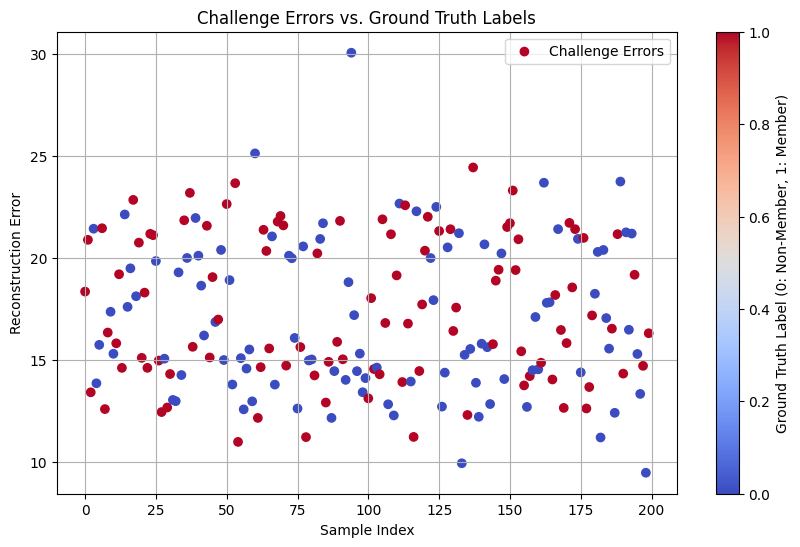

In [303]:
import matplotlib.pyplot as plt

# Assuming challenge_errors and challenge_ground_truth are available as tensors or numpy arrays
challenge_errors = challenge_errors.cpu().numpy() if torch.is_tensor(challenge_errors) else challenge_errors
challenge_ground_truth = challenge_ground_truth if isinstance(challenge_ground_truth, (list, np.ndarray)) else challenge_ground_truth.numpy()

# Plot challenge errors with their ground truth labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(challenge_errors)), challenge_errors, c=challenge_ground_truth, cmap='coolwarm', label='Challenge Errors')
plt.colorbar(label='Ground Truth Label (0: Non-Member, 1: Member)')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Challenge Errors vs. Ground Truth Labels')
plt.legend(['Challenge Errors'])
plt.grid(True)
plt.show()


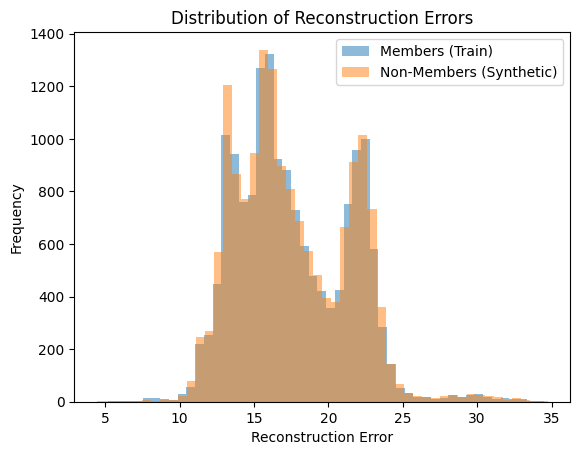

In [82]:
import matplotlib.pyplot as plt

# Compute reconstruction errors for members (train data)
train_errors = compute_reconstruction_errors(train_features, model, t=5)[:16000]
synthetic_train_errors = compute_reconstruction_errors(synthetic_train, model,t =5)

# Plot histograms
plt.hist(train_errors.cpu().numpy(), bins=50, alpha=0.5, label='Members (Train)')
plt.hist(synthetic_train_errors.cpu().numpy(), bins=50, alpha=0.5, label='Non-Members (Synthetic)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Reconstruction Errors')
plt.show()

In [47]:
len(synthetic_train_errors)

16000